In [1]:
import numpy as np
from scipy.sparse import csr_matrix #best for solving the linear system
from scipy.sparse import coo_matrix #recommended to create X
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsqr

# Task 1


In [2]:
def construct_X(M, alphas, Np=None):
    #resolution of sensor, should be odd and large enough
    if Np is None:
        Np = (2 * M-1)        
        
    #this function creates an array so i = i_p + N_p*i_o, 
    def index_N(i,j):
        return (i * Np)
    
    #turn degrees into radiant
    alpha_rad = np.deg2rad(alphas) 
    
    D = M * M  #size of flattend tomogram
    No = alphas.size #size of alphas, x-dim of sinogram
    N = Np * No #total size of sinogram
    
    #holding coordinates of the tomogram pixel center
    a_0 = -M/2+0.5
    b_0 = -M/2+0.5
    jb, ja = np.mgrid[a_0:M/2, b_0:M/2]
    C = np.zeros((2, D)) #save coordinates center here
    C[0] = ja.flatten() #+a_0 as in sheet not needed since its already in the grid
    C[1] = jb.flatten()
        
    #unit vectors (because pixel distance is equal 1) of rotated sensor
    n = np.array([np.cos(alpha_rad), np.sin(alpha_rad)]) 
    #distance between first element and sensor's coordinate origin (just the middle, Np should be odd)
    s0 = (Np - 1) / 2  
    #the projection p of each pixel onto the sensor
    p = np.dot(n.T, C) + s0 #1xD
    
    #Derive weights from decimal part of projection with modulo
    weights = np.concatenate((1 - (p % 1), p % 1)).flatten()
    
    #sensor-element is just the rounded projection
    sensor_element = np.round((p).astype(int),0)
    index_corr = np.fromfunction(index_N, sensor_element.shape) #gives index_N i and j in the range of sensor_element
    sensor_element = (sensor_element + index_corr) #correct i indices
    
    #create i and j indices
    i_ind = np.concatenate((sensor_element, sensor_element + 1)).flatten()
    j_ind = np.tile(np.arange(0, D, 1), 2*No)
    
    #Finally compute X (exercise sheet)
    X = coo_matrix((weights, (i_ind, j_ind)), shape = (N, D), dtype = np.float32)
            
    return X

(45, 100)

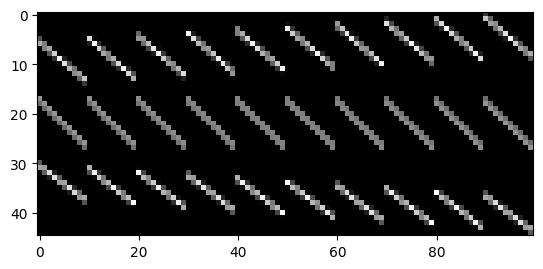

In [3]:
#plot example of exercise sheet
X = construct_X(10, np.array([-33, 1, 42]), Np = 15).todense() #convert sparse matrix to a dense numpy-array
plt.figure()
plt.imshow(X, cmap = 'gray')
X.shape

The visualization fits to the exercise sheet. 

# Task 2

In [4]:
#load datas
alphas_77 = np.load('hs_tomography/alphas_195.npy')
y_77 = np.load('hs_tomography/y_195.npy')
#construct X with the datas
X = construct_X(195, alphas_77, Np = 275).todense()

#convert X to a coo_matrix, so we can use the nnz tool
X_coo = coo_matrix(X)

#number of non-zero entries
non_zero_entries = X_coo.nnz
# number of total entries
total_entries = X_coo.shape[0] * X_coo.shape[1]
#number of zero-entries
zero_entries = total_entries - non_zero_entries
#calculate sparsity
sparsity = zero_entries / total_entries 

print(non_zero_entries, sparsity) 


13535957 0.992768406286928


High sparsity since the ray only ditrubetes along two sensor-elements.


In [5]:
beta, istop, residuals, iter_count = lsqr(X, y_77, atol=1e-05, btol=1e-05)[:4] #lsqr solves the equation X*beta=y

A lower atol and btol leads to better resolution but higher computation time.


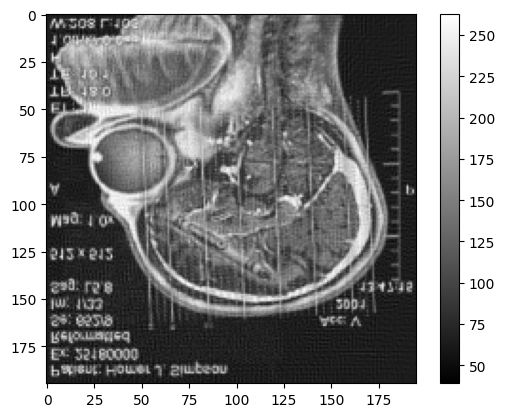

In [6]:
#Reshape beta into the original tomogram mu
beta_2d = beta.reshape((195,195))
#Plot original picture
plt.imshow(beta_2d, cmap='gray')
plt.colorbar()
plt.show()

There seems to be something long and strange in his head, which we should get out immediately.

# Task 3

In [7]:
skip=2 #skip x elements in alpha
alphas_77_red=alphas_77[::skip]
y_77_2d= y_77.reshape((179,275)) #need to reshape y, so we can skip properly
y_77_2d_red=y_77_2d[::skip][:]
y_77_red=y_77_2d_red.flatten() #y has the shape that the first Np elements belong to first alpha and so on

In [8]:
#repeat procedure
X_red = construct_X(195, alphas_77_red, Np = 275).todense()
beta_red, istop_red, residuals_red, iter_count_red = lsqr(X_red, y_77_red, atol=1e-05, btol=1e-05)[:4] 

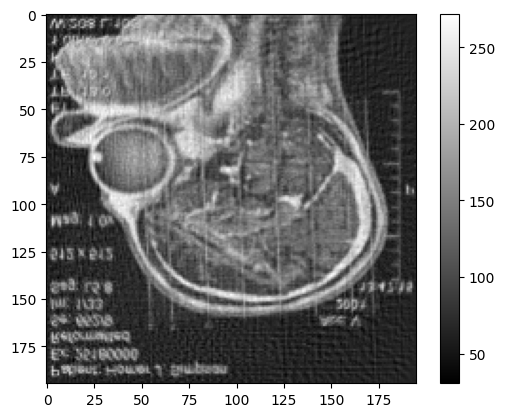

In [9]:
beta_2d_red = beta_red.reshape((195,195))
#Plot original picture
plt.imshow(beta_2d_red, cmap='gray')
plt.colorbar()
plt.show()

As you can see, it is sufficient to take only every second alpha. If you want to keep equal distances in the angles, then this is the minimum, since every third alpha lead to a bad image. If equal distances are not desired you can reduce the set in the following way too:

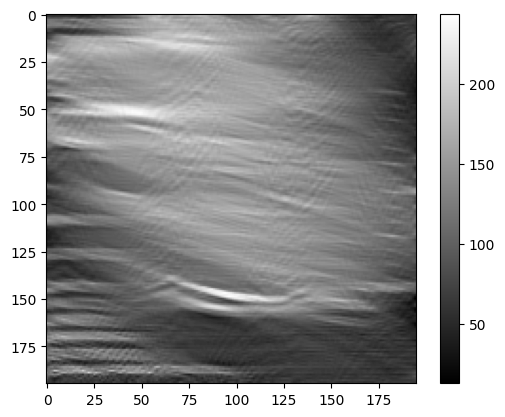

In [10]:
limit=21 #limit limits our array
alphas_77_red2=alphas_77[:limit]
y_77_red2=y_77 [:limit*275]
X_red2 = construct_X(195, alphas_77_red2, Np = 275).todense()
beta_red2, istop_red2, residuals_red2, iter_count_red2 = lsqr(X_red2, y_77_red2, atol=1e-05, btol=1e-05)[:4] #lsqr solves the equation X*beta=y
beta_2d_red2 = beta_red2.reshape((195,195))
#Plot original picture
plt.imshow(beta_2d_red2, cmap='gray')
plt.colorbar()
plt.show()

Here we only took the first 21 alphas (20 was already to bad) and the strange object is recognizable. With this method you need much less number of projection, but give up the equal distanced angles, which is in general very usel to keep, to be sure that you more or less covered the whole range.